In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sythatsokmontrey","key":"de62daa17baf1ccfd9f2f541317e55c0"}'}

In [4]:
!mkdir ~/.kaggle

In [5]:
!cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle competitions download -c leaf-classification

 93% 32.0M/34.3M [00:02<00:00, 22.0MB/s]
100% 34.3M/34.3M [00:02<00:00, 13.4MB/s]


In [8]:
!ls

kaggle.json  leaf-classification.zip  sample_data


In [9]:
!unzip leaf-classification.zip

Archive:  leaf-classification.zip
  inflating: images.zip              
  inflating: sample_submission.csv.zip  
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [10]:
!unzip train.csv.zip
!unzip test.csv.zip
!unzip images.zip

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  images.zip
   creating: images/
  inflating: images/1.jpg            
  inflating: images/10.jpg           
  inflating: images/100.jpg          
  inflating: images/1000.jpg         
  inflating: images/1001.jpg         
  inflating: images/1002.jpg         
  inflating: images/1003.jpg         
  inflating: images/1004.jpg         
  inflating: images/1005.jpg         
  inflating: images/1006.jpg         
  inflating: images/1007.jpg         
  inflating: images/1008.jpg         
  inflating: images/1009.jpg         
  inflating: images/101.jpg          
  inflating: images/1010.jpg         
  inflating: images/1011.jpg         
  inflating: images/1012.jpg         
  inflating: images/1013.jpg         
  inflating: images/1014.jpg         
  inflating: images/1015.jpg         
  inflating: images/1016.jpg         
  inflating: images/1017.jpg         

In [11]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset

import torchvision as tv

import PIL
from PIL import Image

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import os

import matplotlib.pyplot as plt

In [12]:
t.manual_seed(101)
device = t.device("cuda:0" if t.cuda.is_available() else "cpu")
# device = xla.device()

img_dir = 'images/'
csv_dir = 'train.csv'

img_filenames_list = os.listdir(img_dir)
dataframe = pd.read_csv(csv_dir)
dataframe['species'] = dataframe['species'].astype('category').cat.codes
dataframe.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,3,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,49,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,65,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,94,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,84,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


In [34]:
class LeafDataset(Dataset):
    def __init__(self, images_dir, dataframe, transform):
        self.images_dir = images_dir
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = str(int(self.dataframe.iloc[idx]['id'])) + ".jpg"
        img_dir = os.path.join(self.images_dir, img_name)

        # img = Image.open(img_dir)
        img = tv.io.read_image(img_dir)
        img = img.to(device)
        img = self.transform(img)
        label = self.dataframe.iloc[idx]['species']
        label = t.tensor(label, dtype=t.int64)
        label = label.to(device)
        return img, label

In [35]:
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
BATCH_SIZE = 512
TEST_SIZE = 0.2
NUM_TRAIN_DATASET_RESPEAT = 15 # repeat the dataset with augmentation to increase the number of samples
NUM_TEST_DATASET_RESPEAT = 3

train_df, test_df = train_test_split(dataframe, test_size=TEST_SIZE)
len(train_df) * NUM_TRAIN_DATASET_RESPEAT, len(test_df) * NUM_TRAIN_DATASET_RESPEAT

(11880, 2970)

In [36]:
train_transform = tv.transforms.Compose([
    tv.transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
    # tv.transforms.RandomHorizontalFlip(),
    tv.transforms.RandomRotation(45),
    tv.transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    # tv.transforms.ToTensor(), # using read_image already converts to tensor
    tv.transforms.Lambda(lambda x: x/255.0), # normalize the image and to float
])

test_transform = tv.transforms.Compose([
    tv.transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
    # tv.transforms.RandomHorizontalFlip(),
    # tv.transforms.RandomRotation(45),
    # tv.transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    # tv.transforms.ToTensor(), # using read_image already converts to tensor
    tv.transforms.Lambda(lambda x: x/255.0), # normalize the image and to float
])

train_ds = LeafDataset(img_dir, dataframe=train_df, transform=train_transform)
test_ds = LeafDataset(img_dir, dataframe=test_df, transform=test_transform)

# increase the number of samples by repeating the dataset multiple times
# while augmenting each of them slightly differently
augmented_train_ds = ConcatDataset([train_ds for _ in range(NUM_TRAIN_DATASET_RESPEAT)])
augmented_test_ds = ConcatDataset([test_ds for _ in range(NUM_TEST_DATASET_RESPEAT)])

train_dl = DataLoader(augmented_train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(augmented_test_ds, batch_size=BATCH_SIZE, shuffle=True)

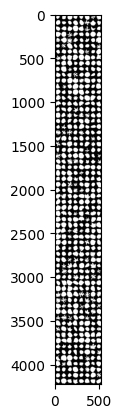

In [38]:
# get some random training images to check the data
img, label = next(iter(train_dl))
# make a grid from batch
out = tv.utils.make_grid(img)
plt.imshow(out[1].cpu().numpy(), cmap='gray')

In [39]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # original image size: 64 x 64
        self.conv1 = nn.Conv2d(1, 32, 3) # -> 62 x 62
        # max pool -> 31 x 31
        self.conv2 = nn.Conv2d(32, 64, 3) # -> 29 x 29
        # max pool again -> 14 x 14
        self.conv3 = nn.Conv2d(64, 128, 3) # -> 12 x 12
        # max pool again -> 6 x 6
        self.layer1 = nn.Linear(128 * 6 * 6, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 99)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = t.flatten(x, 1)
        x = self.dropout(x)
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        # x = self.softmax(x) # disabled for CrossEntropyLoss
        return x

In [40]:
def train(model, train_dl, loss_func, optimizer):
    model.train()
    total_loss = 0
    for i, (img, label) in enumerate(train_dl):
        optimizer.zero_grad()
        pred = model.forward(img)
        loss = loss_func(pred, label)
        loss.backward()
        optimizer.step()
        # xm.optimizer_step(optimizer)
        total_loss += loss.item()
        print(f"Batch: {i}/{len(train_dl)}, Loss: {loss.item()}", end='\r')
    return total_loss / len(train_dl)

def test(model, test_dl, loss_func):
    model.eval()
    total_loss = 0
    with t.no_grad():
        for i, (img, label) in enumerate(test_dl):
          # with xla.step():
            pred = model.forward(img)
            loss = loss_func(pred, label)
            total_loss += loss.item()
    return total_loss / len(test_dl)

def fit(model, train_dl, test_dl, loss_func, optimizer, epochs, callback):
    for epoch in range(epochs):
        train_loss = train(model, train_dl, loss_func, optimizer)
        test_loss = test(model, test_dl, loss_func)
        callback(epoch, train_loss, test_loss, model)

In [41]:
model = Model()
model.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch: 0, Train loss: 4.4354620178540545, Test loss: 4.250391244888306
Epoch: 1, Train loss: 3.613996277252833, Test loss: 3.274493455886841
Epoch: 2, Train loss: 3.0885959366957345, Test loss: 2.8690165281295776
Epoch: 3, Train loss: 2.8118211328983307, Test loss: 2.7019981145858765
Epoch: 4, Train loss: 2.6209616661071777, Test loss: 2.355669379234314
Epoch: 5, Train loss: 2.481098175048828, Test loss: 2.3889057636260986
Epoch: 6, Train loss: 2.3263284961382547, Test loss: 2.3532090187072754
Epoch: 7, Train loss: 2.1903542578220367, Test loss: 2.404115676879883
Epoch: 8, Train loss: 2.0876139799753823, Test loss: 2.2008016109466553
Epoch: 9, Train loss: 1.996815840403239, Test loss: 2.2573717832565308
Epoch: 10, Train loss: 1.8886782278617222, Test loss: 2.092288017272949
Epoch: 11, Train loss: 1.8625330279270809, Test loss: 2.093396782875061
Epoch: 12, Train loss: 1.812532514333725, Test loss: 2.2510757446289062
Epoch: 13, Train loss: 1.7398506502310436, Test loss: 2.044030845165252

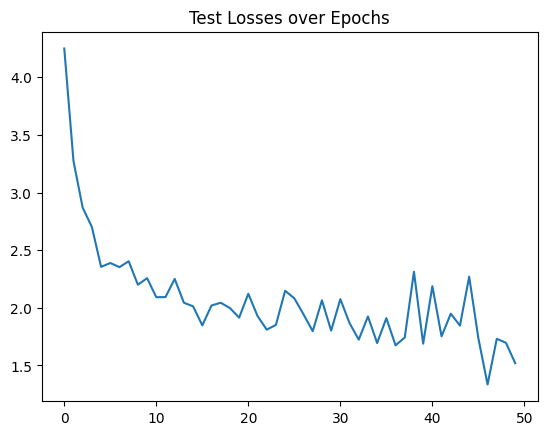

In [42]:
epochs = 50
losses = []

def callback(epoch, train_loss, test_loss, model):
    print(f"Epoch: {epoch}, Train loss: {train_loss}, Test loss: {test_loss}")
    losses.append([epoch, train_loss, test_loss])
    if epoch % 5 == 0:
      model_path = f"./models/model_{epoch}.pth"
      t.save(model.state_dict(), model_path)

fit(model,
    train_dl,
    test_dl,
    loss_func,
    optimizer,
    epochs,
    callback)

model_path = f"./models/model_final.pth"
t.save(model.state_dict(), model_path)

losses = np.array(losses)
plt.title('Test Losses over Epochs')
plt.plot(losses[:, 0], losses[:, 2], label='test')

In [43]:
t.cuda.empty_cache()

In [50]:
img_dir = 'images/'
train_csv_dir = 'train.csv'
eval_csv_dir = 'test.csv'

img_filenames_list = os.listdir(img_dir)
eval_df = pd.read_csv(eval_csv_dir)
train_df = pd.read_csv(train_csv_dir)

In [51]:
eval_ids = eval_df['id']
eval_ids = eval_ids.to_list()
len(eval_ids)

594

In [64]:
transform = tv.transforms.Compose([
    tv.transforms.Resize((64, 64)),
    tv.transforms.Lambda(lambda x: x / 255.0)
])

def readImage(id):
    eval_img_dir = img_dir + str(id) + '.jpg'
    img_tensor = tv.io.read_image(eval_img_dir)
    img_tensor = transform(img_tensor)
    img_tensor = img_tensor.unsqueeze(0)
    return img_tensor

eval_inputs = t.cat([readImage(id) for id in eval_ids], dim=0)
eval_inputs = eval_inputs.to(device)

In [67]:
class EvalModel(nn.Module):
    def __init__(self):
        super().__init__()
        # original image size: 64 x 64
        self.conv1 = nn.Conv2d(1, 32, 3) # -> 62 x 62
        # max pool -> 31 x 31
        self.conv2 = nn.Conv2d(32, 64, 3) # -> 29 x 29
        # max pool again -> 14 x 14
        self.conv3 = nn.Conv2d(64, 128, 3) # -> 12 x 12
        # max pool again -> 6 x 6
        self.layer1 = nn.Linear(128 * 6 * 6, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 99)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = t.flatten(x, 1)
        x = self.dropout(x)
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        x = self.softmax(x) # disabled for CrossEntropyLoss
        return x

In [68]:
model_path = f"./models/model_final.pth"
model = EvalModel()
model.load_state_dict(t.load(model_path))
model.to(device)

EvalModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (layer1): Linear(in_features=4608, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=99, bias=True)
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (softmax): Softmax(dim=1)
)

In [69]:
pred = model.forward(eval_inputs)
pred = pred.detach().cpu().numpy()

categories = train_df['species'].astype('category').cat.categories
pd.set_option('display.float_format', lambda x: '%.3f' % x)
submission_df = pd.DataFrame(columns=categories)
submission_df['id'] = eval_df['id']
for i in range(99):
    submission_df[categories[i]] = pred[:, 98-i]

submission_df.to_csv('submission.csv', index=False)